In [54]:
import cs_vqe_classes.cs_vqe_circuit as cs_circ
import utils.plotting_tools as plot
import utils.qonversion_tools as qonvert
from utils.molecule_tools import get_molecule
from utils.cs_vqe_tools import greedy_dfs
from matplotlib import pyplot as plt
import numpy as np
from qiskit.aqua.components.optimizers import IMFIL, NELDER_MEAD, POWELL, NFT, SPSA, SLSQP

In [55]:
speciesname = "LiH_STO-3G_SINGLET"
molecule    = get_molecule(speciesname, taper=True)
num_qubits  = molecule['num_qubits']
ham         = molecule['hamiltonian']
uccsd       = molecule['uccsdansatz']
hf_config   = molecule['hf_config']

Coov


In [56]:
terms_noncon = greedy_dfs(ham, 2, criterion='size')[-1]
#terms_noncon = ['IIIIIIII', 'IZIZZZIZ', 'ZIZIZZZI', 'IIIIIZII', 'IIIIZIII', 'IZIIIIII', 'ZIIIIIII', 'IIIZIIII', 'IIZIIIII', 'ZZZZIIZZ', 'IIIIIIZI', 'IIIIIIIZ', 'IIIIZZII', 'IZIZIZIZ', 'IZIZZIIZ', 'ZIZIIZZI', 'ZIZIZIZI', 'IIIXIIZX', 'IIIYIIZY', 'IZIIIZII', 'IZIIZIII', 'ZIIIIZII', 'ZIIIZIII', 'IIIZIZII', 'IIIZZIII', 'IIZIIZII', 'IIZIZIII', 'IIIIIZIZ', 'IIIIIZZI', 'IIIIZIIZ', 'IIIIZIZI', 'ZZIZZZIZ', 'ZZZIZZZI', 'IIIZZZIZ', 'IIZIZZZI', 'IZZZZZIZ', 'ZIZZZZZI', 'IZIIZZIZ', 'ZIIIZZZI', 'IZIZZZZZ', 'ZIZIZZZZ', 'ZZIIIIII', 'IZIZZZII', 'ZIZIZZII', 'IIZZIIII', 'IZZIIIII', 'ZIIZIIII', 'IIIIIIZZ', 'IZIIIIZI', 'ZIIIIIIZ', 'IIIZIIZI', 'IIZIIIIZ', 'IZIZIIII', 'ZIZIIIII', 'IZIIIIIZ', 'ZIIIIIZI', 'IIIZIIIZ', 'IIZIIIZI', 'IIIXIZZX', 'IIIXZIZX', 'IIIYIZZY', 'IIIYZIZY', 'ZIZXZZIX', 'ZIZYZZIY', 'IZIXZZZX', 'IZIYZZZY', 'ZIIXIIZX', 'ZIIYIIZY', 'IZIXIIZX', 'IZIYIIZY', 'IIZXIIZX', 'IIZYIIZY', 'IIIXIIIX', 'IIIYIIIY']
mol_circ = cs_circ.cs_vqe_circuit(hamiltonian = ham,
                                  terms_noncon= terms_noncon,
                                  num_qubits  = num_qubits,
                                  hf_config   = hf_config)

num_sim_q = mol_circ.chem_acc_num_q
print('%s reaches chemical accuracy for %i-qubit CS-VQE' % (speciesname, num_sim_q))

LiH_STO-3G_SINGLET reaches chemical accuracy for 4-qubit CS-VQE


4-qubit reduced Hamiltonian: {'IIII': (-6.99589146221835+0j), 'IIIZ': (-0.36527194496106685+0j), 'IIZI': (-0.3652719449742213+0j), 'IIZZ': (0.1138439882028706+0j), 'ZIZX': (-0.010952643670348584+0j), 'ZIIX': (-0.019389788757442745+0j), 'IIZX': (0.010952643666419983+0j), 'IIIX': (0.019389788736546953+0j), 'ZIIZ': (-0.21189016280995449+0j), 'ZIII': (0.09275797351489036+0j), 'ZIZZ': (0.06044027504124192+0j), 'ZXXZ': (-0.009002518932431015+0j), 'IXXX': (0.006587549438925726+0j), 'ZXXX': (-0.0065875494453351445+0j), 'IXXI': (0.019389788703847503+0j), 'IXXZ': (0.010952643666419983+0j), 'ZYYZ': (-0.009002518932431015+0j), 'IYYX': (0.006587549438925726+0j), 'ZYYX': (-0.0065875494453351445+0j), 'IYYI': (0.019389788703847503+0j), 'IYYZ': (0.010952643666419983+0j), 'IZII': (-0.21189016280037173+0j), 'IZIZ': (0.06044027505833447+0j), 'IZZI': (0.09275797354366924+0j), 'ZZIX': (0.009002518940839886+0j), 'IZIX': (-0.009002518925725757+0j), 'ZZIZ': (0.08460154569678831+0j), 'XIII': (0.0119251188537325

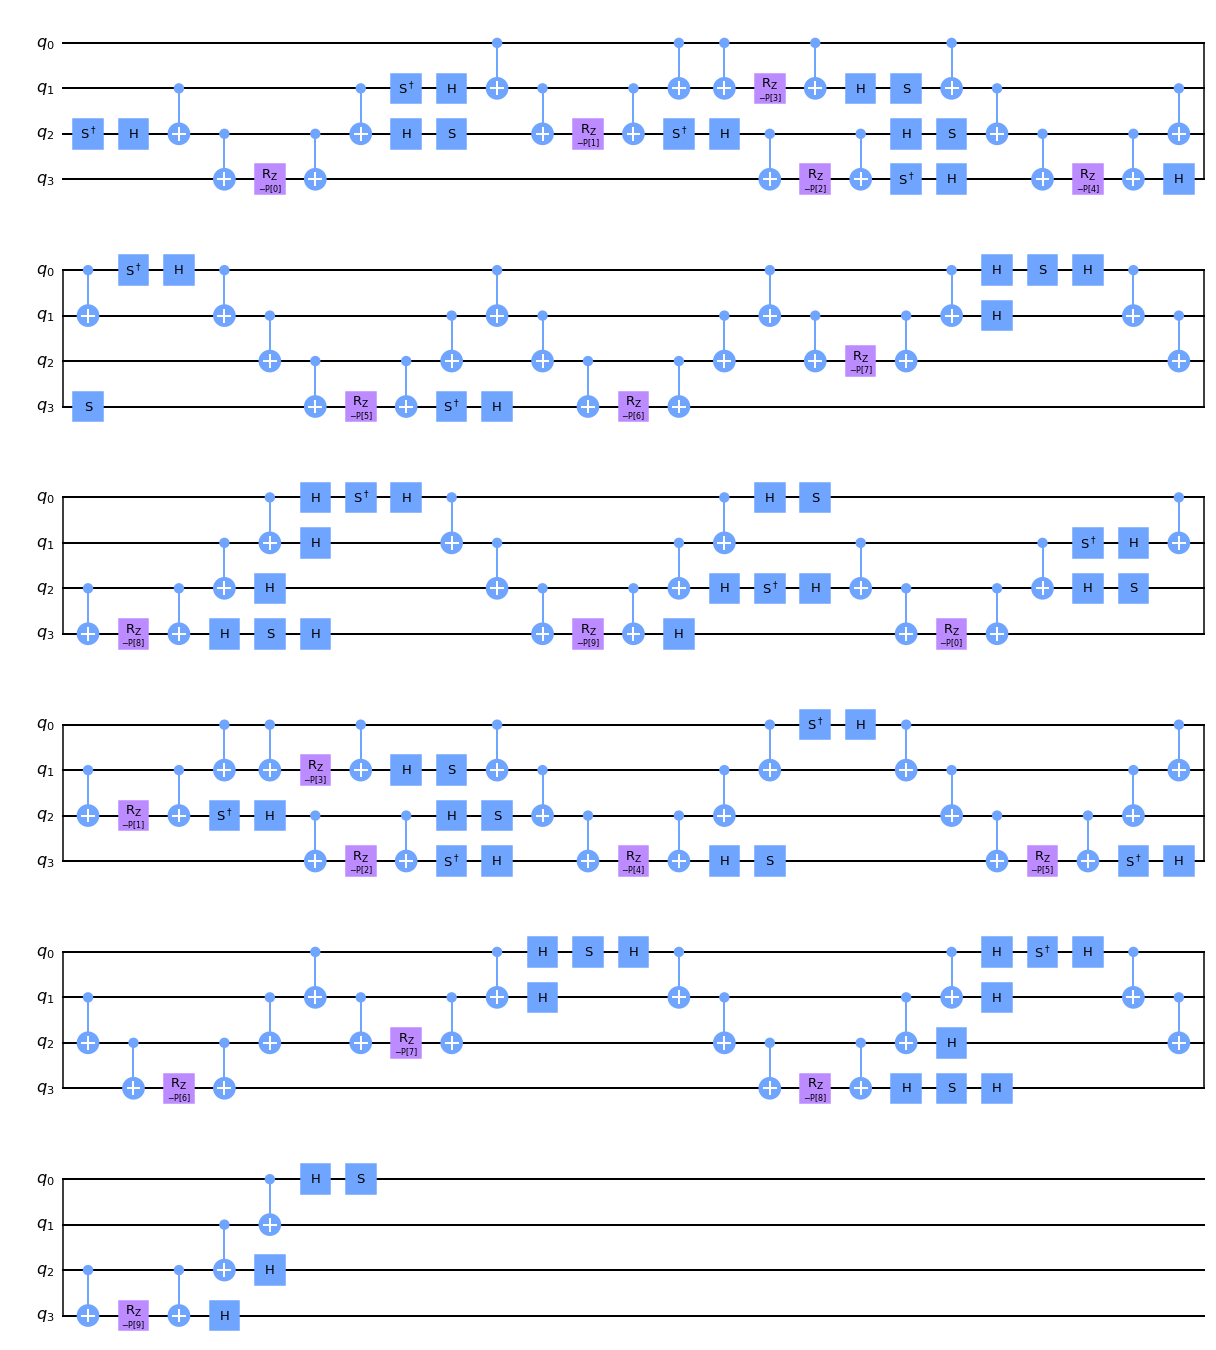

In [84]:
anz_op_order_by_amp = list(list(zip(*sorted(uccsd.items(), key=lambda x: abs(x[1]))))[0])
anz_op_order_by_amp.reverse()
anz = {op:uccsd[op] for op in anz_op_order_by_amp[:5]}
#anz = uccsd

ham_red = mol_circ.ham_reduced[num_sim_q]
anz_red = mol_circ.project_anz_terms(anz, num_sim_q)
init_params = np.array([v.imag for v in anz_red.values()])
bounds = np.array([(p-np.pi, p+np.pi) for p in init_params])

qc = mol_circ.build_circuit(anz, num_sim_q)
qc.parameter_bounds = bounds

print('%i-qubit reduced Hamiltonian:'%num_sim_q, ham_red, '\n')
print('%i-qubit reduced Ansatz:'%num_sim_q, anz_red, '\n')
print('Corresponding reduced Ansatz circuit:')
qc.draw(output='mpl')

# Performing the simulation *without* noise

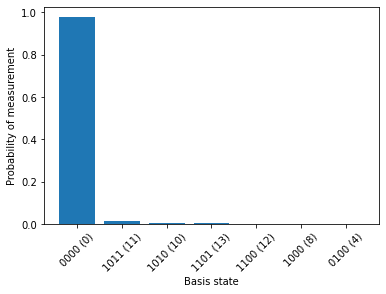

*   Performing 4-qubit CS-VQE over qubit positions 6, 5, 1, 0 ...


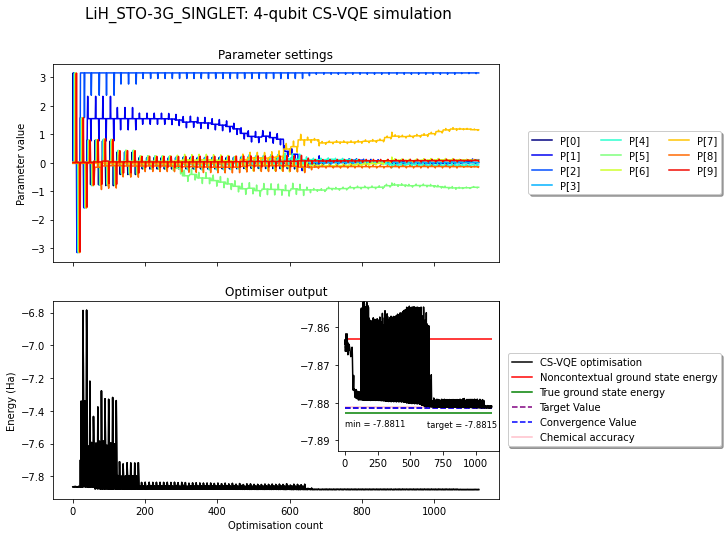

In [85]:
cs_vqe_results = mol_circ.CS_VQE(anz_terms=anz, 
                                 num_sim_q=num_sim_q, 
                                 optimizer=IMFIL(maxiter=10000), 
                                 param_bound=np.pi,
                                 noise=False)

title = '%s: %i-qubit CS-VQE simulation' % (speciesname, num_sim_q)
fig = plot.plot_parameter_settings(cs_vqe_results, title=title)

# Performing the simulation *with* noise

The noise model used below emulates IBM's 5-qubit Vigo device, derived from real-life performance data

In [62]:
import os
from qiskit.algorithms import VQE
from qiskit import Aer
from qiskit.utils import QuantumInstance, algorithm_globals
from qiskit.providers.aer import QasmSimulator
from qiskit.providers.aer.noise import NoiseModel
from qiskit.test.mock import FakeVigo, FakeTenerife, FakeMelbourne, FakeRueschlikon, FakeTokyo
from qiskit.ignis.mitigation.measurement import CompleteMeasFitter, TensoredMeasFitter

In [63]:
def get_quantum_instance(seed, noise=False, error_mitigation=None):
    algorithm_globals.random_seed = seed
    
    if not noise:
        backend = Aer.get_backend('statevector_simulator')
        qi = QuantumInstance(backend=backend, seed_simulator=seed, seed_transpiler=seed)
    
    else:
        device_backend = FakeRueschlikon()
        backend = Aer.get_backend('aer_simulator')
        noise_model = None
        device = QasmSimulator.from_backend(device_backend)
        coupling_map = device.configuration().coupling_map
        noise_model = NoiseModel.from_backend(device)
        basis_gates = noise_model.basis_gates
        
        qi = QuantumInstance(backend=backend,
                             shots=2**11,
                             seed_simulator=seed, 
                             seed_transpiler=seed,
                             coupling_map=coupling_map, 
                             noise_model=noise_model,
                             measurement_error_mitigation_cls=error_mitigation,
                             measurement_error_mitigation_shots=2**13,
                             cals_matrix_refresh_period=30)
        
    return qi

In [64]:
def vqe_simulation(ansatz, operator, init_params, noise=False, error_mitigation=None):
    
    def store_intermediate_result(eval_count, parameters, mean, std):
        """ Outputs intermediate data during VQE routine
        """
        counts.append(eval_count)
        prmset.append(parameters)
        values.append(mean)
        errors.append(std)
    
    counts=[]
    prmset=[]
    values=[]
    errors=[]
    
    qi = get_quantum_instance(seed=42, noise=noise, error_mitigation=error_mitigation)
    vqe = VQE(ansatz, 
              initial_point=init_params, 
              optimizer=IMFIL(maxiter=1000), 
              callback=store_intermediate_result, 
              quantum_instance=qi) 
    vqe_input_op = qonvert.dict_to_WeightedPauliOperator(operator)
    vqe_run = vqe.compute_minimum_eigenvalue(operator=vqe_input_op)
    
    return {'conval':vqe_run.optimal_value,
            'counts':counts,
            'prmset':prmset,
            'values':values,
            'errors':errors}

In [65]:
noiseless        = vqe_simulation(ansatz=qc, 
                                  operator=ham_red, 
                                  init_params=init_params, 
                                  noise=False, 
                                  error_mitigation=None)
print('Noiseless VQE error:', noiseless['conval']-mol_circ.true_gs)

noisy            = vqe_simulation(ansatz=qc, 
                                operator=ham_red, 
                                init_params=init_params, 
                                noise=True, 
                                error_mitigation=None)
print('Noisy VQE error:', noisy['conval']-mol_circ.true_gs)

noisy_mitigation = vqe_simulation(ansatz=qc, 
                                operator=ham_red, 
                                init_params=init_params, 
                                noise=True, 
                                error_mitigation=CompleteMeasFitter)#TensoredMeasFitter)
print('Noisy VQE with error mitigation error:', noisy_mitigation['conval']-mol_circ.true_gs)

x_lim = max([noiseless['counts'][-1], noisy['counts'][-1], noisy_mitigation['counts'][-1]])

fig, ax = plt.subplots(figsize=(10,10))

#ax.hlines(mol_circ.true_gs, 1, x_lim, color='g', label='True ground state energy', ls='--')
#ax.hlines(mol_circ.true_gs+0.0016, 1, x_lim, color='pink', label='Chemical accuracy', ls='--')
#ax.hlines(mol_circ.gs_noncon_energy, 1, x_lim, color='red', label='Noncon gs energy', ls='--')
ax.hlines(np.log10(0.0016), 1, x_lim, color='red', label='Chemicial accuracy', ls='--')

ax.plot(noiseless['counts'], [np.log10(abs(v-mol_circ.true_gs)) for v in noiseless['values']], label='Noiseless simulation')
ax.plot(noisy['counts'], [np.log10(abs(v-mol_circ.true_gs)) for v in noisy['values']], label='Noisy simulation')
ax.plot(noisy_mitigation['counts'], [np.log10(abs(v-mol_circ.true_gs)) for v in noisy_mitigation['values']], label='Noisy simulation with error mitigation')

ax.set_xlabel('Optimisation count')
ax.set_ylabel('Logarithmic error (log10(Ha))')
ax.legend()

Noiseless VQE error: 0.0021125276908273705


Process ForkProcess-9372:
Process ForkProcess-9371:
FAILURE: Can not get job id, Resubmit the qobj to get job id. Terra job error: 'Keyboard interrupt in parallel_map.' 
Process ForkProcess-9376:
Process ForkProcess-9374:
Process ForkProcess-9375:
Process ForkProcess-9373:
Process ForkProcess-9370:
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/home/tim/anaconda3/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/tim/anaconda3/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/tim/anaconda3/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/tim/anaconda3/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/t

KeyboardInterrupt
  File "/home/tim/anaconda3/lib/python3.7/multiprocessing/queues.py", line 93, in get
    with self._rlock:
  File "/home/tim/anaconda3/lib/python3.7/multiprocessing/synchronize.py", line 96, in __enter__
    return self._semlock.__enter__()
  File "/home/tim/anaconda3/lib/python3.7/multiprocessing/connection.py", line 216, in recv_bytes
    buf = self._recv_bytes(maxlength)
  File "/home/tim/anaconda3/lib/python3.7/multiprocessing/synchronize.py", line 96, in __enter__
    return self._semlock.__enter__()
KeyboardInterrupt
  File "/home/tim/anaconda3/lib/python3.7/multiprocessing/connection.py", line 407, in _recv_bytes
    buf = self._recv(4)
KeyboardInterrupt
  File "/home/tim/anaconda3/lib/python3.7/multiprocessing/connection.py", line 379, in _recv
    chunk = read(handle, remaining)
KeyboardInterrupt
Process ForkProcess-9597:
Process ForkProcess-9659:
FAILURE: Can not get job id, Resubmit the qobj to get job id. Terra job error: 'Keyboard interrupt in parallel_m

  File "/home/tim/anaconda3/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "/home/tim/anaconda3/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "/home/tim/anaconda3/lib/python3.7/concurrent/futures/process.py", line 226, in _process_worker
    call_item = call_queue.get(block=True)
  File "/home/tim/anaconda3/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/tim/anaconda3/lib/python3.7/concurrent/futures/process.py", line 241, in _process_worker
    del call_item
  File "/home/tim/anaconda3/lib/python3.7/concurrent/futures/process.py", line 226, in _process_worker
    call_item = call_queue.get(block=True)
  File "/home/tim/anaconda3/lib/python3.7/concurrent/futures/process.py", line 226, in _process_worker
    call_item = call_queue.get(block=True)
  File "/home/tim/anaconda3/lib/python3.7/multiprocessing/queues.

  File "/home/tim/anaconda3/lib/python3.7/multiprocessing/synchronize.py", line 96, in __enter__
    return self._semlock.__enter__()
  File "/home/tim/anaconda3/lib/python3.7/multiprocessing/queues.py", line 93, in get
    with self._rlock:
  File "/home/tim/anaconda3/lib/python3.7/multiprocessing/queues.py", line 94, in get
    res = self._recv_bytes()
  File "/home/tim/anaconda3/lib/python3.7/multiprocessing/synchronize.py", line 96, in __enter__
    return self._semlock.__enter__()
  File "/home/tim/anaconda3/lib/python3.7/concurrent/futures/process.py", line 226, in _process_worker
    call_item = call_queue.get(block=True)
  File "/home/tim/anaconda3/lib/python3.7/multiprocessing/queues.py", line 93, in get
    with self._rlock:
Traceback (most recent call last):

During handling of the above exception, another exception occurred:

  File "/home/tim/anaconda3/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/tim/anaconda3/lib/python3.

  File "/home/tim/anaconda3/lib/python3.7/multiprocessing/queues.py", line 93, in get
    with self._rlock:
  File "/home/tim/anaconda3/lib/python3.7/multiprocessing/queues.py", line 113, in get
    return _ForkingPickler.loads(res)
  File "/home/tim/anaconda3/lib/python3.7/multiprocessing/connection.py", line 216, in recv_bytes
    buf = self._recv_bytes(maxlength)
  File "/home/tim/anaconda3/lib/python3.7/multiprocessing/synchronize.py", line 96, in __enter__
    return self._semlock.__enter__()
  File "/home/tim/anaconda3/lib/python3.7/multiprocessing/synchronize.py", line 96, in __enter__
    return self._semlock.__enter__()
  File "/home/tim/anaconda3/lib/python3.7/multiprocessing/synchronize.py", line 96, in __enter__
    return self._semlock.__enter__()
  File "/home/tim/anaconda3/lib/python3.7/site-packages/sympy/core/numbers.py", line 1042, in __new__
    def __new__(cls, num, dps=None, prec=None, precision=None):
  File "/home/tim/anaconda3/lib/python3.7/multiprocessing/synch

  File "/home/tim/anaconda3/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/tim/anaconda3/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/tim/anaconda3/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
FAILURE: Can not get job id, Resubmit the qobj to get job id. Terra job error: 'Keyboard interrupt in parallel_map.' 
  File "/home/tim/anaconda3/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/tim/anaconda3/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/tim/anaconda3/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/tim/anaconda3/lib/python3.7/multiprocessing/queues.py", line 93, in get
    with self._rlock:
  File "/home/tim/anaconda3/lib/python3.7/concurrent/futures/process.py", line 226, in _process_worker
    call_it

  File "/home/tim/anaconda3/lib/python3.7/concurrent/futures/process.py", line 226, in _process_worker
    call_item = call_queue.get(block=True)
  File "/home/tim/anaconda3/lib/python3.7/multiprocessing/queues.py", line 93, in get
    with self._rlock:
  File "/home/tim/anaconda3/lib/python3.7/multiprocessing/queues.py", line 93, in get
    with self._rlock:
  File "/home/tim/anaconda3/lib/python3.7/multiprocessing/queues.py", line 93, in get
    with self._rlock:
  File "/home/tim/anaconda3/lib/python3.7/concurrent/futures/process.py", line 226, in _process_worker
    call_item = call_queue.get(block=True)
  File "/home/tim/anaconda3/lib/python3.7/concurrent/futures/process.py", line 226, in _process_worker
    call_item = call_queue.get(block=True)
  File "/home/tim/anaconda3/lib/python3.7/multiprocessing/queues.py", line 94, in get
    res = self._recv_bytes()
  File "/home/tim/anaconda3/lib/python3.7/multiprocessing/queues.py", line 93, in get
    with self._rlock:
  File "/home/t

  File "/home/tim/anaconda3/lib/python3.7/multiprocessing/synchronize.py", line 96, in __enter__
    return self._semlock.__enter__()
  File "/home/tim/anaconda3/lib/python3.7/multiprocessing/connection.py", line 407, in _recv_bytes
    buf = self._recv(4)
  File "/home/tim/anaconda3/lib/python3.7/multiprocessing/connection.py", line 379, in _recv
    chunk = read(handle, remaining)
KeyboardInterrupt
KeyboardInterrupt
KeyboardInterrupt
KeyboardInterrupt
FAILURE: Can not get job id, Resubmit the qobj to get job id. Terra job error: 'Keyboard interrupt in parallel_map.' 
Process ForkProcess-9735:
Process ForkProcess-9734:
FAILURE: Can not get job id, Resubmit the qobj to get job id. Terra job error: 'Keyboard interrupt in parallel_map.' 
Process ForkProcess-9738:
Process ForkProcess-9737:
Process ForkProcess-9739:
Process ForkProcess-9736:
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/home/tim/anaconda3/lib/python3.7/mul

KeyboardInterrupt: 

In [86]:
from qiskit import IBMQ

with open('data/token.txt', 'r') as file:
    TOKEN = file.read()

IBMQ.save_account(TOKEN, overwrite=True)

In [87]:
IBMQ.load_account()

ibmqfactory.load_account:WARNING:2021-10-13 19:29:36,366: Credentials are already in use. The existing account in the session will be replaced.


<AccountProvider for IBMQ(hub='ibm-q', group='open', project='main')>

In [88]:
provider = IBMQ.get_provider(hub='ibm-q')
backend = provider.get_backend('ibmq_manila')

In [89]:
from qiskit_nature.runtime import VQEProgram

In [90]:
intermediate_info = {
    'nfev': [],
    'parameters': [],
    'energy': [],
    'stddev': []
}

def callback(nfev, parameters, energy, stddev):
    intermediate_info['nfev'].append(nfev)
    intermediate_info['parameters'].append(parameters)
    intermediate_info['energy'].append(energy)
    intermediate_info['stddev'].append(stddev)

In [91]:
# currently the VQEProgram supports only 'SPSA' and 'QN-SPSA'
optimizer = {
    'name': 'QN-SPSA',  # leverage the Quantum Natural SPSA
    # 'name': 'SPSA',  # set to ordinary SPSA
    'maxiter': 100,
    'resamplings': {1: 100},  # 100 samples of the QFI for the first step, then 1 sample per step
}

runtime_vqe = VQEProgram(ansatz=qc,
                         optimizer=optimizer,
                         initial_point=init_params,
                         provider=provider,
                         backend=backend,
                         shots=1024,
                         measurement_error_mitigation=True,
                         callback=callback)  # use a complete measurement fitter for error mitigation

In [92]:
vqe_input_op = qonvert.dict_to_WeightedPauliOperator(ham_red)
runtime_result = runtime_vqe.compute_minimum_eigenvalue(vqe_input_op)

runtime_job._start_websocket_client:WARNING:2021-10-13 19:43:35,659: An error occurred while streaming results from the server for job c5jib9t7js99mk9lk68g:
Traceback (most recent call last):
  File "/home/tim/anaconda3/lib/python3.7/site-packages/qiskit/providers/ibmq/runtime/runtime_job.py", line 328, in _start_websocket_client
    self._ws_client.job_results()
  File "/home/tim/anaconda3/lib/python3.7/site-packages/qiskit/providers/ibmq/api/clients/runtime_ws.py", line 74, in job_results
    self.stream(url=url, retries=max_retries, backoff_factor=backoff_factor)
  File "/home/tim/anaconda3/lib/python3.7/site-packages/qiskit/providers/ibmq/api/clients/base.py", line 211, in stream
    raise WebsocketError(error_message)
qiskit.providers.ibmq.api.exceptions.WebsocketError: 'Max retries exceeded: Failed to establish a websocket connection. Error: Traceback (most recent call last):\n  File "/home/tim/anaconda3/lib/python3.7/site-packages/websocket/_app.py", line 369, in run_forever\n  

In [93]:
runtime_result.eigenvalue

(-7.025656338669208+0j)

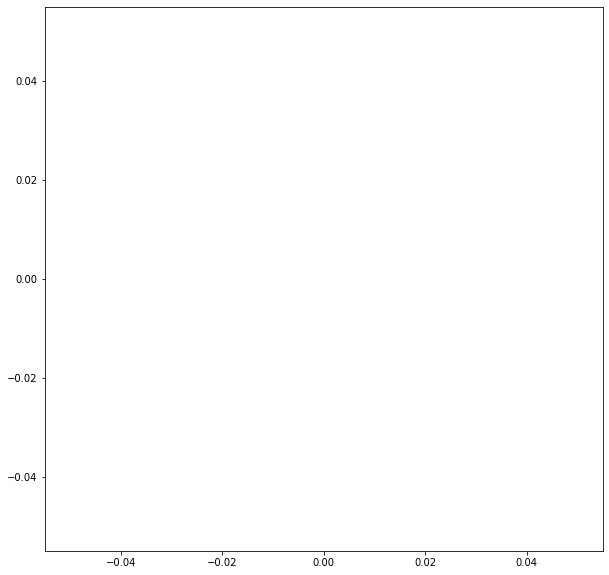

In [94]:
fig, ax = plt.subplots(figsize=(10,10))

ax.plot(intermediate_info['nfev'], intermediate_info['energy'])

In [95]:
#import json 

#data={}
#for k in intermediate_info.keys():
#    data[str(k)] = intermediate_info[k]

#data['parameters'] = [list(t) for t in data['parameters']]
#data['stddev'] = [t.real for t in data['stddev']]

#with open("data/IBMQ-runtime/"+speciesname+"_UCCSD_taper_CS-VQE_convergence_projected_ansatz.json", "w") as outfile: 
#    json.dump(data, outfile)

In [102]:
#intermediate_info['nfev'] = list(range(len(runtime_result.optimizer_history['loss'])))
#intermediate_info['energy'] = runtime_result.optimizer_history['loss']
#intermediate_info['parameters'] = runtime_result.optimizer_history['params']

parameters={}
for index, param in enumerate([p.name for p in list(qc.parameters)]):
    parameters[param] = list(zip(*intermediate_info['parameters']))[index]
    
data={'counts':intermediate_info['nfev'],
      'values':intermediate_info['energy'],
      'params':parameters,
      'errors':[t.real for t in intermediate_info['stddev']],
      'true_gs':mol_circ.true_gs,
      'result':runtime_result.optimal_value,
      'target':mol_circ.cs_vqe_energy[num_sim_q],
      'gs_noncon_energy':mol_circ.gs_noncon_energy}

In [103]:
import json 

with open("data/IBMQ-runtime/"+speciesname+"_UCCSD_taper_CS-VQE_convergence_projected_ansatz.json", "w") as outfile: 
    json.dump(data, outfile)

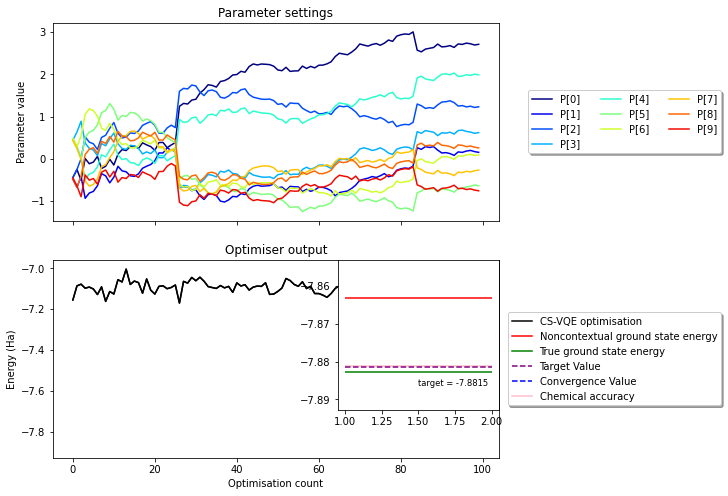

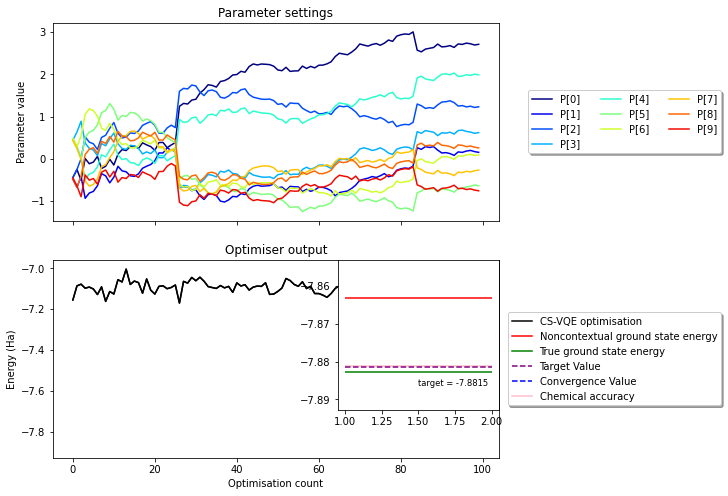

In [104]:
plot.plot_parameter_settings(data)

In [101]:
intermediate_info

{'nfev': [0,
  1,
  2,
  3,
  4,
  5,
  6,
  7,
  8,
  9,
  10,
  11,
  12,
  13,
  14,
  15,
  16,
  17,
  18,
  19,
  20,
  21,
  22,
  23,
  24,
  25,
  26,
  27,
  28,
  29,
  30,
  31,
  32,
  33,
  34,
  35,
  36,
  37,
  38,
  39,
  40,
  41,
  42,
  43,
  44,
  45,
  46,
  47,
  48,
  49,
  50,
  51,
  52,
  53,
  54,
  55,
  56,
  57,
  58,
  59,
  60,
  61,
  62,
  63,
  64,
  65,
  66,
  67,
  68,
  69,
  70,
  71,
  72,
  73,
  74,
  75,
  76,
  77,
  78,
  79,
  80,
  81,
  82,
  83,
  84,
  85,
  86,
  87,
  88,
  89,
  90,
  91,
  92,
  93,
  94,
  95,
  96,
  97,
  98,
  99],
 'parameters': [array([-0.44214114, -0.47962554, -0.44214114,  0.44214114,  0.47962554,
          0.44214114,  0.47962554,  0.44214114, -0.47482683, -0.44693985]),
  array([-0.25016212, -0.67160456, -0.25016212,  0.63412016,  0.28764652,
          0.25016212,  0.28764652,  0.25016212, -0.66680585, -0.63891887]),
  array([-0.50515724, -0.41660944,  0.00483299,  0.88911527,  0.03265141,
         -0.0